In [4]:
%matplotlib notebook

import glob, os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import scipy.signal as sig

import librosa
import librosa.display
import IPython.display as ipd

##Do all of the imports and setup inline plotting

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.interpolate import InterpolatedUnivariateSpline

from ripser import ripser
from persim import plot_diagrams
import scipy.io.wavfile

from persim import plot_diagrams as plot_dgms
from scipy import sparse
import ipywidgets as widgets

from IPython.display import clear_output


In [5]:
#path_data="C:/Users/YaniGiorgio/Desktop/Giorgio/Birdsong/ZF_syntax/isolates/ZFr93w56"
#path_data = r"C:\Users\feliz\Documents\aprendiendo python rapido\machine learning\tesis"
path_data= r"C:\Users\feliz\Documents\aprendiendo python rapido\tesis"

os.chdir(path_data)

file_list=glob.glob("*.wav")
file_path=file_list[-1]
print(file_list)

['zfbr118.WAV', 'zfbr77.WAV', 'zfr36.WAV', 'zfr9.WAV', 'zfv52.WAV', 'zfv69.WAV', 'zfw19.WAV', 'zfy34.WAV']


In [6]:
file_path

'zfy34.WAV'

In [7]:
rate, data = wavfile.read(file_path)
rate

<ipython-input-7-c2fa8a2fb249>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(file_path)


32000

<IPython.core.display.Javascript object>


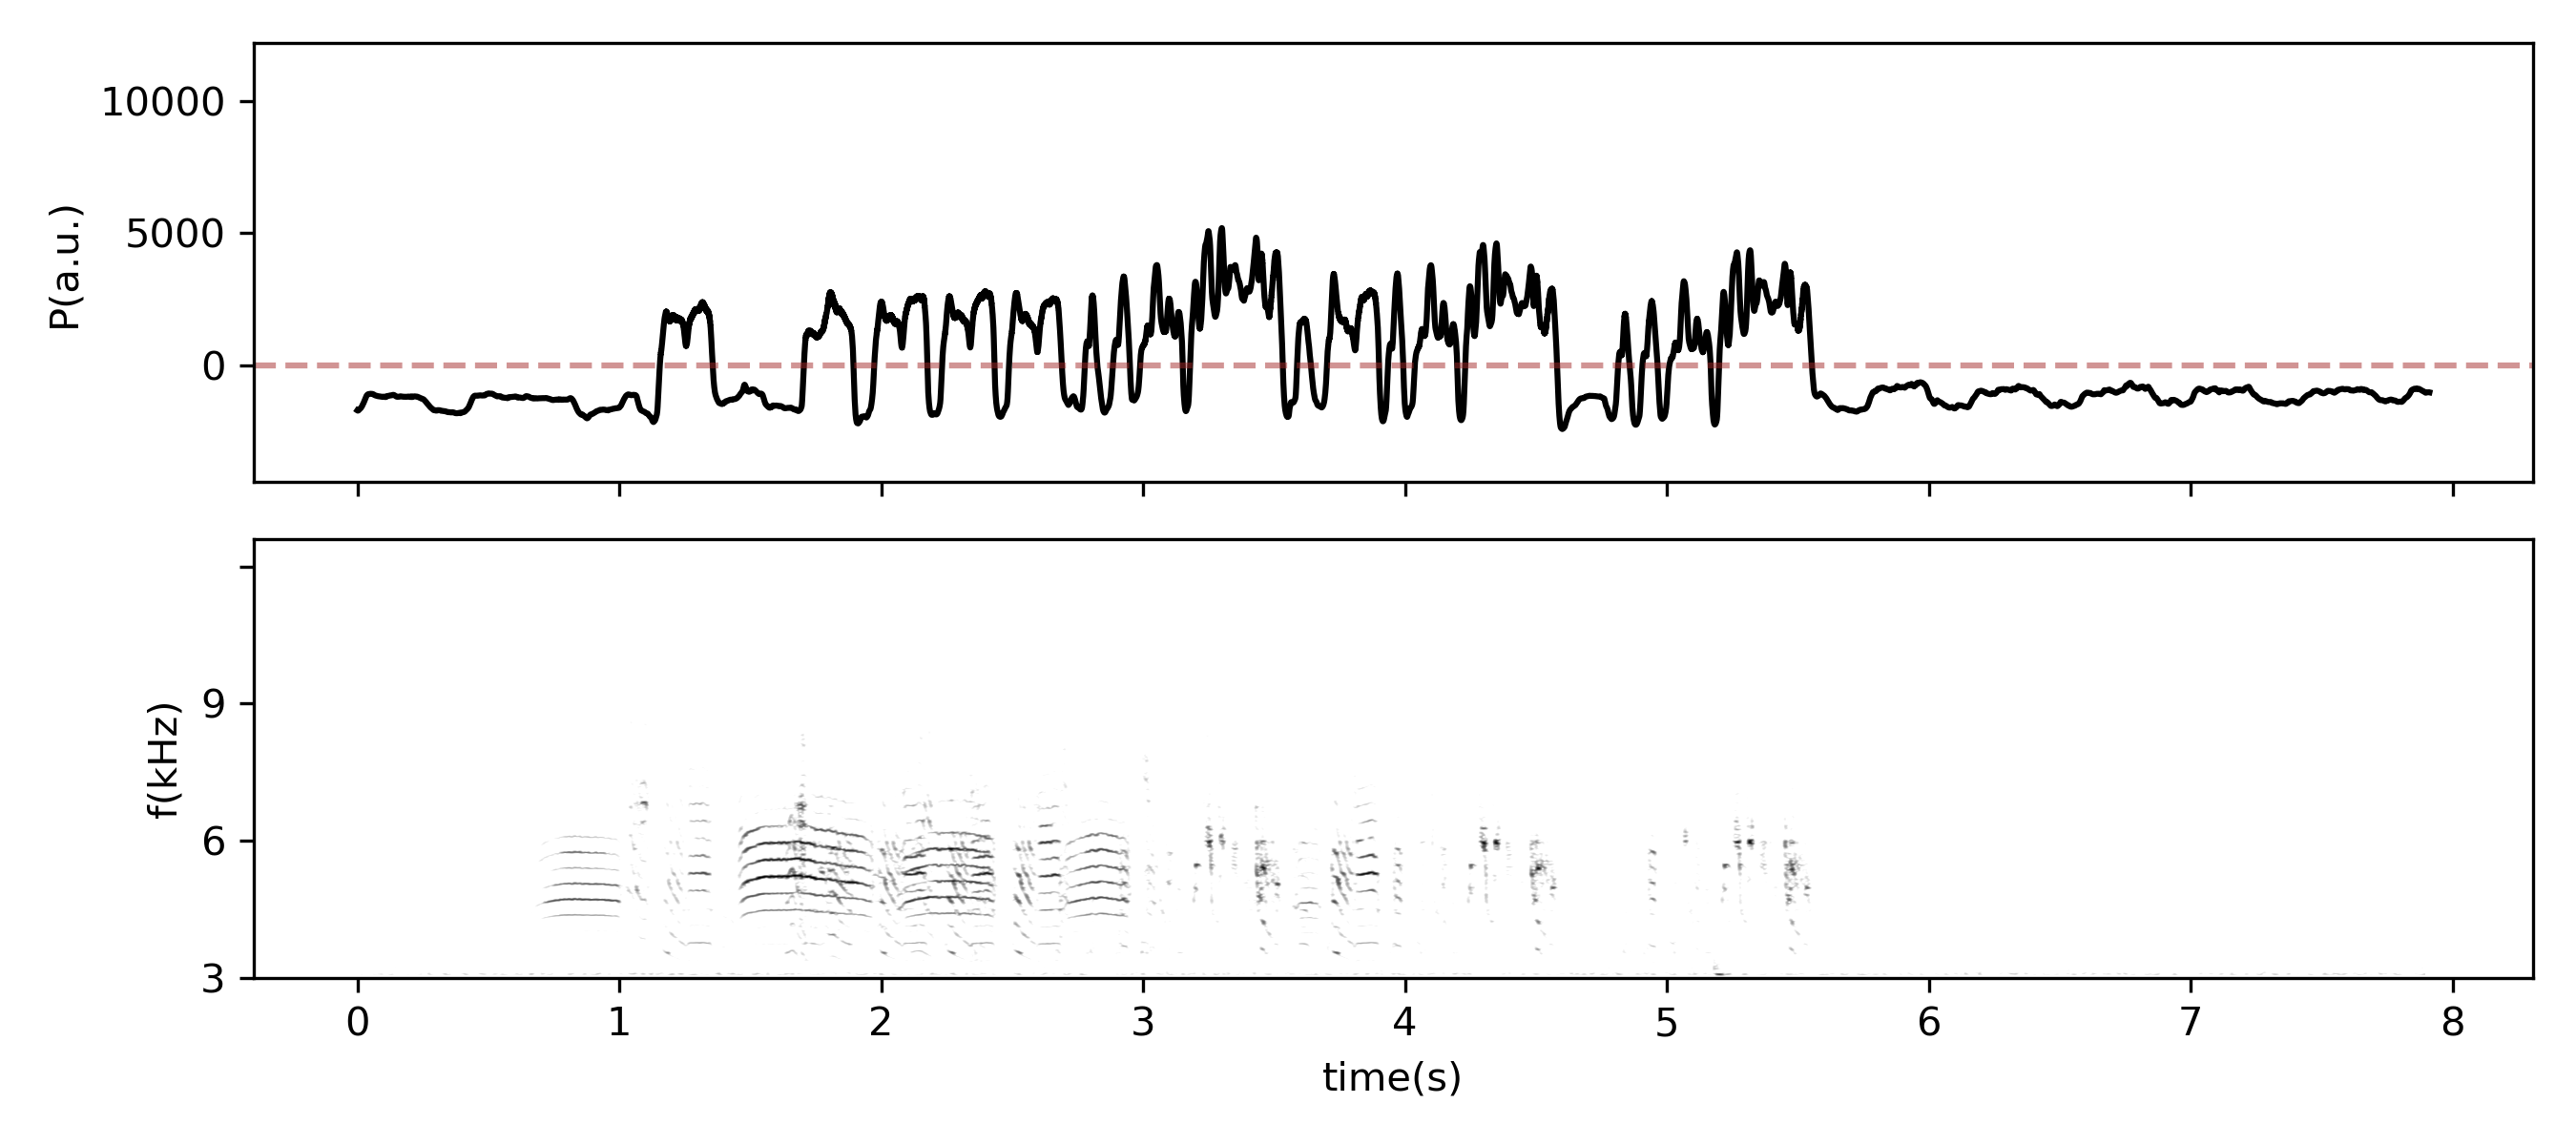

<ipython-input-8-f1149c5d6bba>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['3', '6', '9'])


In [8]:
#rate, data = wavfile.read(file_path)
data = np.array(data)
pressure = data[:,0]
song = data[:,1]
pressure_fil = sig.savgol_filter(pressure, 101, 2)
t = np.linspace(0, len(pressure)/rate, len(pressure))
thr = 2000
pressure_fil = pressure_fil - thr

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 4))

ax1.plot(t, pressure_fil, c='k')

nfft = 1024
fs = rate
lowcut = 100
highcut = 10000 #esta parte es importante para poder hacer la grafica

nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
order = 5
b, a = sig.butter(order, [low, high], btype='band')
song_f = sig.lfilter(b, a, song)

kwargs={}
#kwargs['norm'] = 'Normalize'
kwargs['vmin'] = 5
kwargs['vmax'] = 30
kwargs['interpolation'] = 'bicubic'



ax2.specgram(song_f, NFFT=nfft, Fs=fs, noverlap=900, cmap='Greys', **kwargs)
#ax2.set_ylim(100, 10000)
#ax2.set_yticks([3000, 6000, 9000])
ax2.set_yticklabels(['3', '6', '9'])

ax1.axhline(y=0, color='brown', linestyle='--', alpha=0.5)
ax1.set_ylabel('P(a.u.)')
ax2.set_xlabel('time(s)')
ax2.set_ylabel('f(kHz)')



#ax1.set_xlim(2.87, 4.0)
ax1.set_ylim(pressure.min() - 4000, pressure.max() + 5000)
plt.tight_layout()

In [9]:
pc = pressure_fil[int(rate*2.87):int(rate*4)]

#pc = pressure_fil[int(rate*2.87):int(rate*4.7)]


In [10]:
print(pc)

[-1505.29904253 -1504.21350193 -1503.21145124 ... -1514.2107434
 -1517.48735942 -1520.91714803]


In [11]:
import matplotlib.gridspec as gridspec



#Sliding window code here assumes integer x, dim, and Tau so no interpolation
#is needed (for computational efficiency)
def getSlidingWindowInteger(x, dim, Tau, dT):
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) #The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) #Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        #Figure out the indices of the samples in this window
        idxx = np.array(dT*i + Tau*np.arange(dim), dtype=np.int32)
                
        X[i, :] = x[idxx]
    return X




<IPython.core.display.Javascript object>


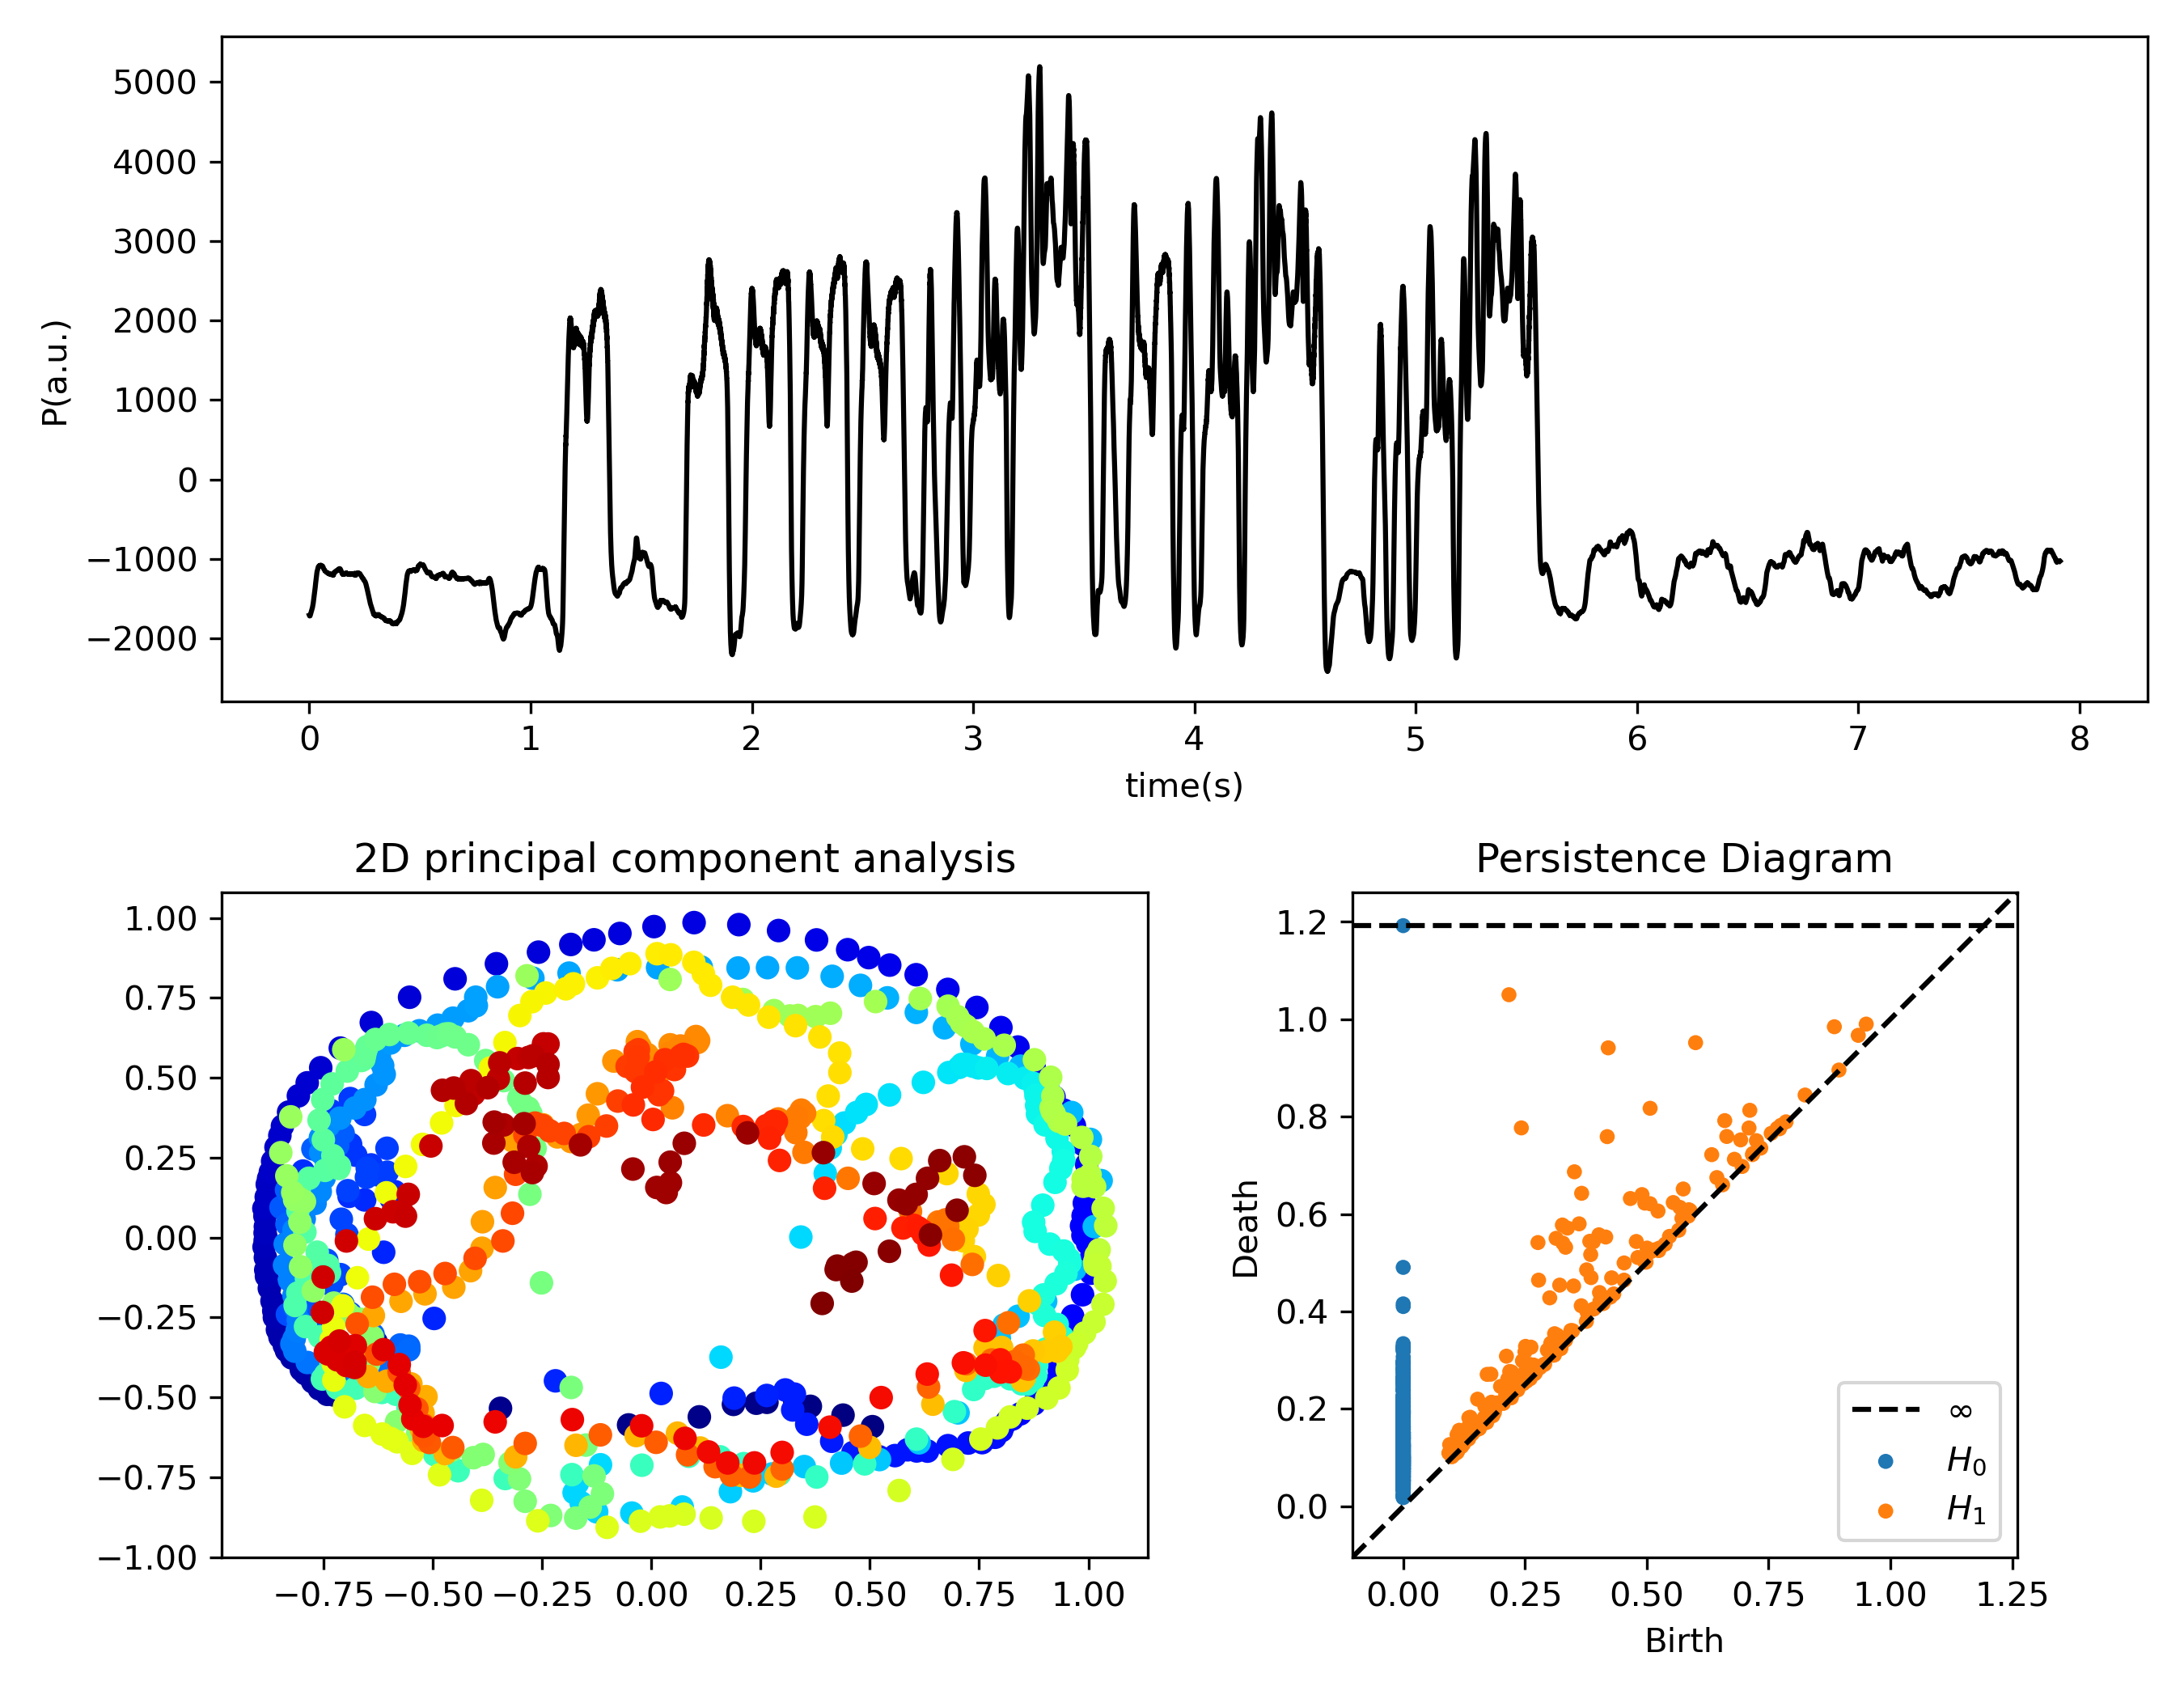

In [12]:
#Note that dim*Tau here spans a half a second of audio, 
#since Fs is the sample rate

sr=fs
dim = 9
Tau = 900
dT = fs/300

#Get the sliding window embedding
Y = getSlidingWindowInteger(pressure_fil[0:fs*3], dim, Tau, dT)
#print("Y.shape = ", Y.shape)

#Mean-center and normalize
Y = Y - np.mean(Y, 1)[:, None]
Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]

# Do Rips Filtration
PDs = ripser(Y, maxdim=1)['dgms']
pca = PCA()
Z = pca.fit_transform(Y)
I = PDs[1]

fig = plt.figure(figsize=(9, 7))
spec = fig.add_gridspec(2, 2)

ax1=fig.add_subplot(spec[0, :])

ax1.set_ylabel('P(a.u.)')
ax1.set_xlabel('time(s)')
ax1.plot(t, pressure_fil, c='k')

c = plt.get_cmap('jet')
C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
C = C[:, 0:3]

ax2=fig.add_subplot(spec[1, 0])
ax2.set_title("2D principal component analysis")
ax2.scatter(Z[:, 0], Z[:, 1],c=C)

ax3=fig.add_subplot(spec[1, 1])

plot_diagrams(PDs)
#plt.title("Max Persistence = %.3g"%np.max(I[:, 1] - I[:, 0]))
plt.title("Persistence Diagram")


# tight_layout works to automatically adjust the graph sizes, and avoid overlapping  
plt.tight_layout()
plt.show()


Y.shape =  (483, 5)


<IPython.core.display.Javascript object>


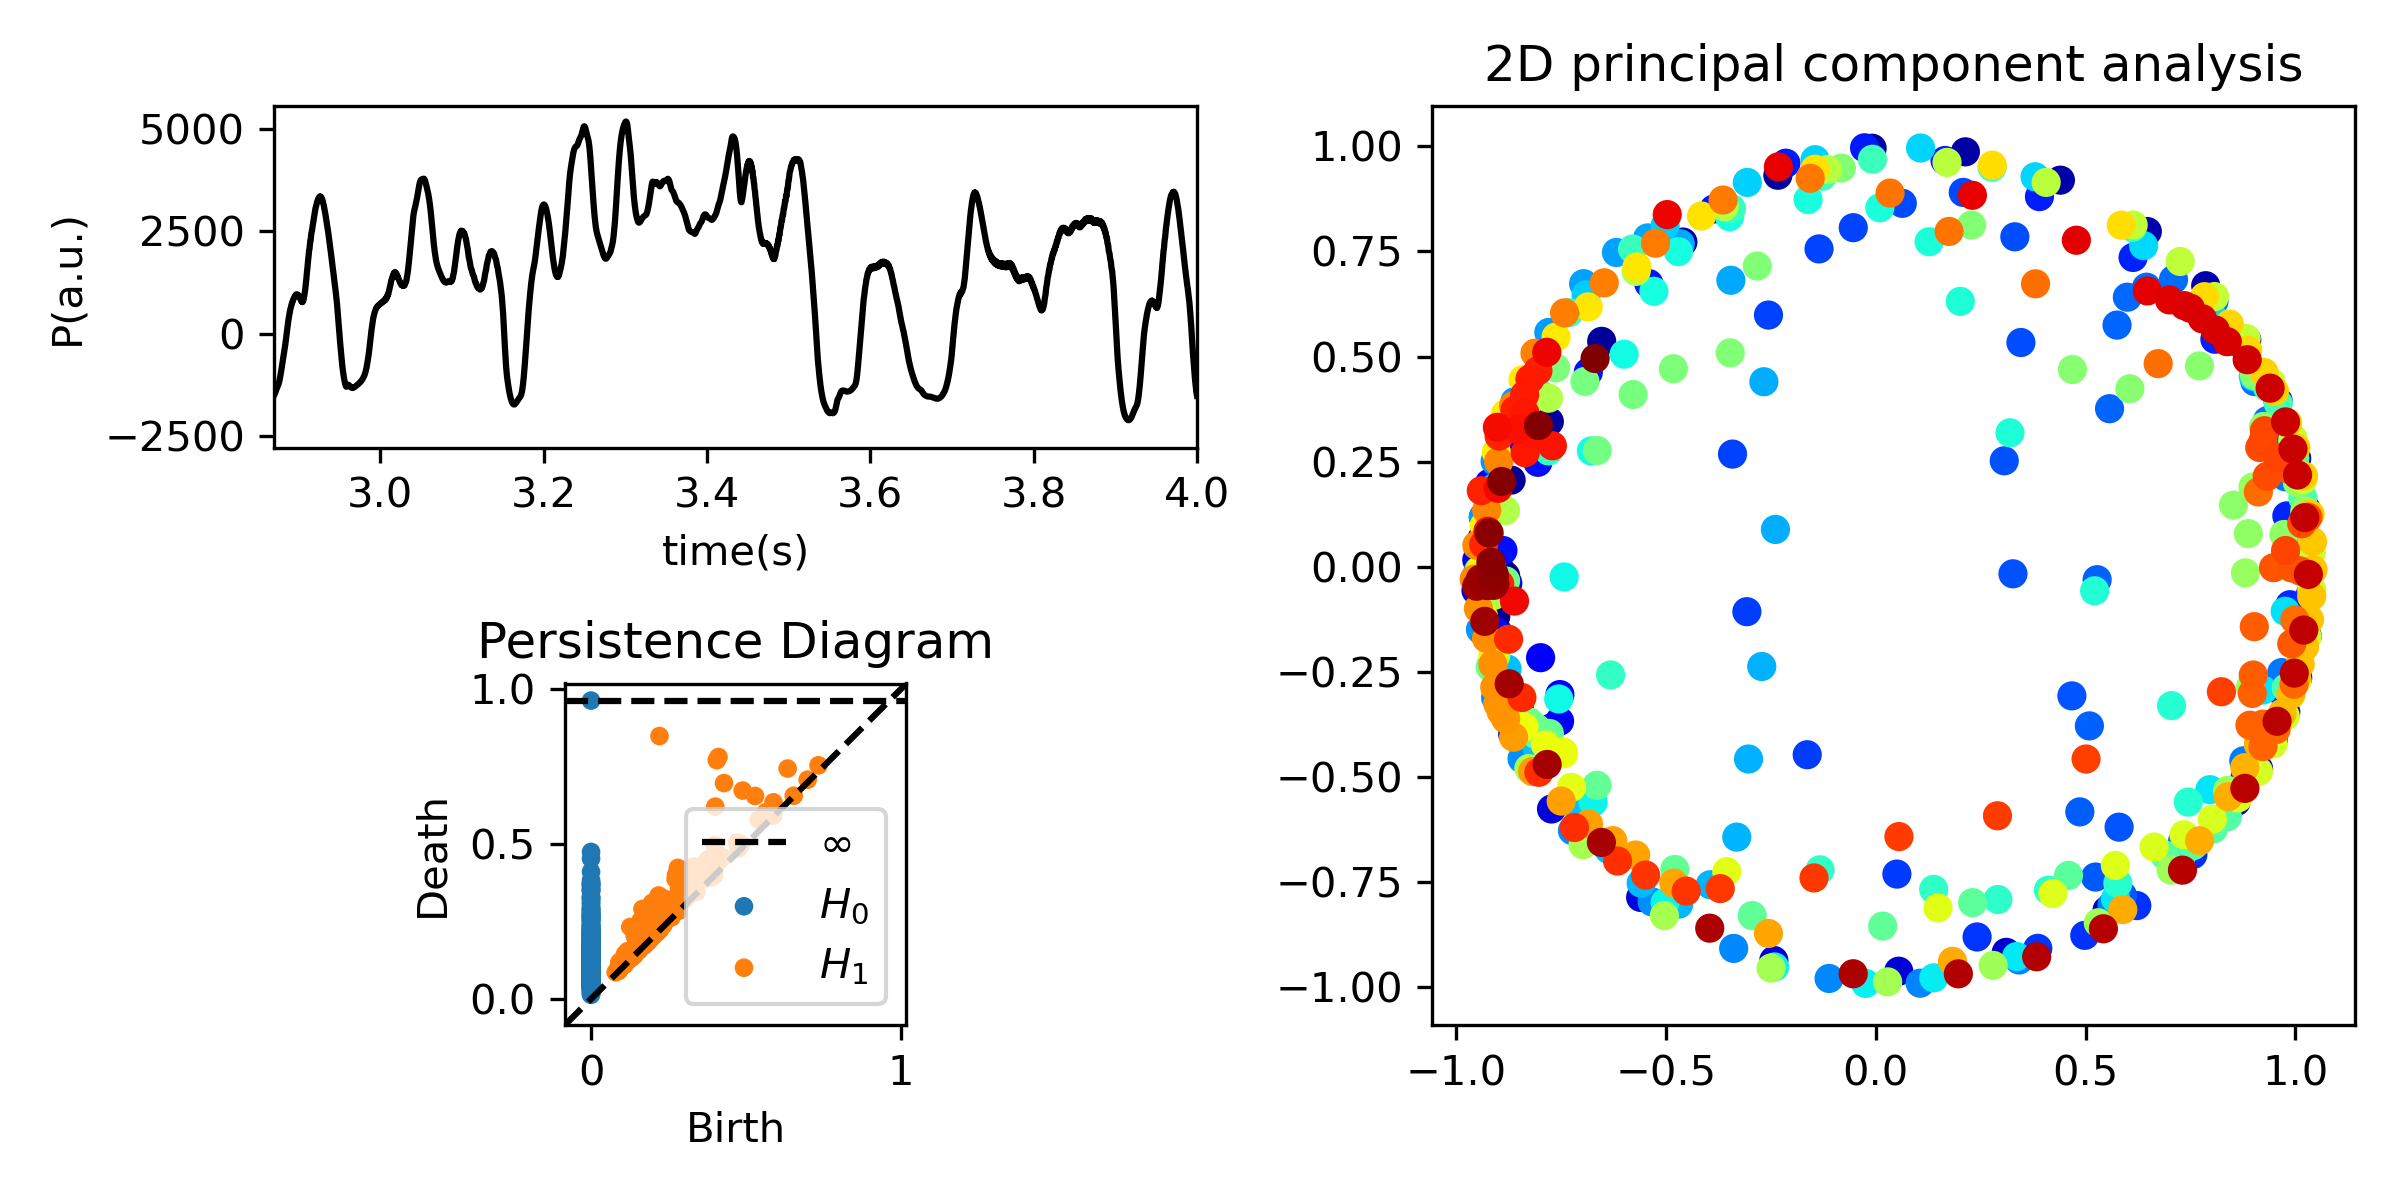

In [13]:

#dim = round(fs/200)

dim=5
Tau = 350
dT = fs/450

Y = getSlidingWindowInteger(pc[0:fs*3], dim, Tau, dT)
print("Y.shape = ", Y.shape)

#Mean-center and normalize
Y = Y - np.mean(Y, 1)[:, None]
Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]

# Do Rips Filtration
PDs = ripser(Y, maxdim=1)['dgms']
pca = PCA()
Z = pca.fit_transform(Y)
I = PDs[1]


plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0,0])
ax1.set_ylabel('P(a.u.)')
ax1.set_xlabel('time(s)')
ax1.plot(t, pressure_fil, c='k')
ax1.set_xlim(2.87, 4.0)


#ax1.set_xlim(2.87, 4.7)
#ax1.set_ylim(pressure.min() - 4000, pressure.max() + 5000)


c = plt.get_cmap('jet')
C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
C = C[:, 0:3]
ax2 = plt.subplot(gs[:,1])
ax2.set_title("2D principal component analysis")
ax2.scatter(Z[:, 0], Z[:, 1],c=C)

ax3=plt.subplot(gs[1,0])

plot_diagrams(PDs)
#plt.title("Max Persistence = %.3g"%np.max(I[:, 1] - I[:, 0]))
plt.title("Persistence Diagram")


# tight_layout works to automatically adjust the graph sizes, and avoid overlapping  
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


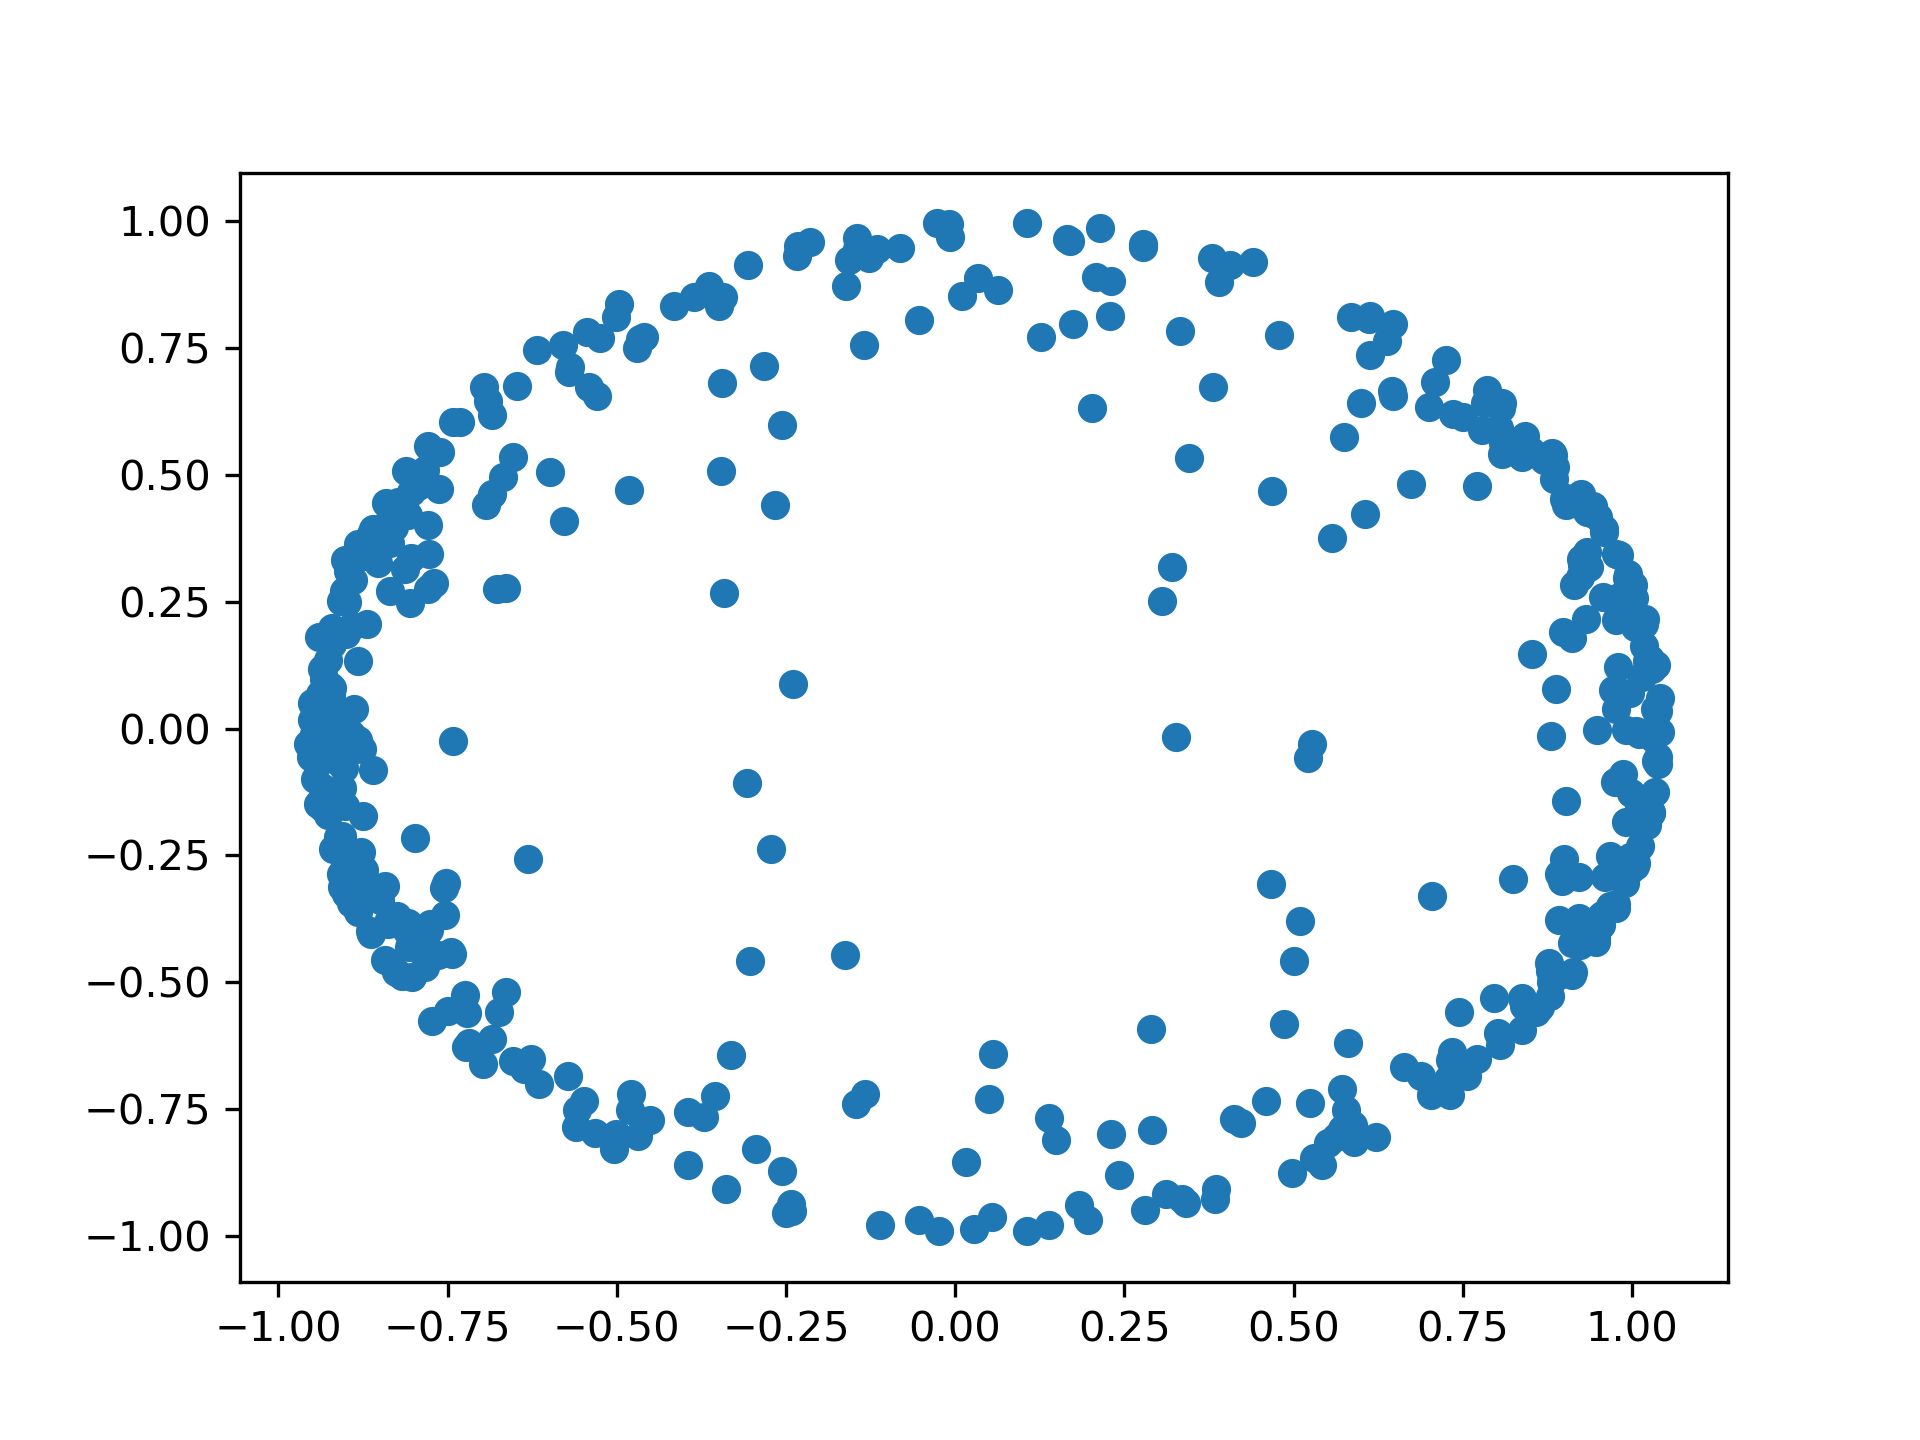

In [14]:
fig, ax = plt.subplots()
ax.scatter(Z[:, 0], Z[:, 1])


<IPython.core.display.Javascript object>


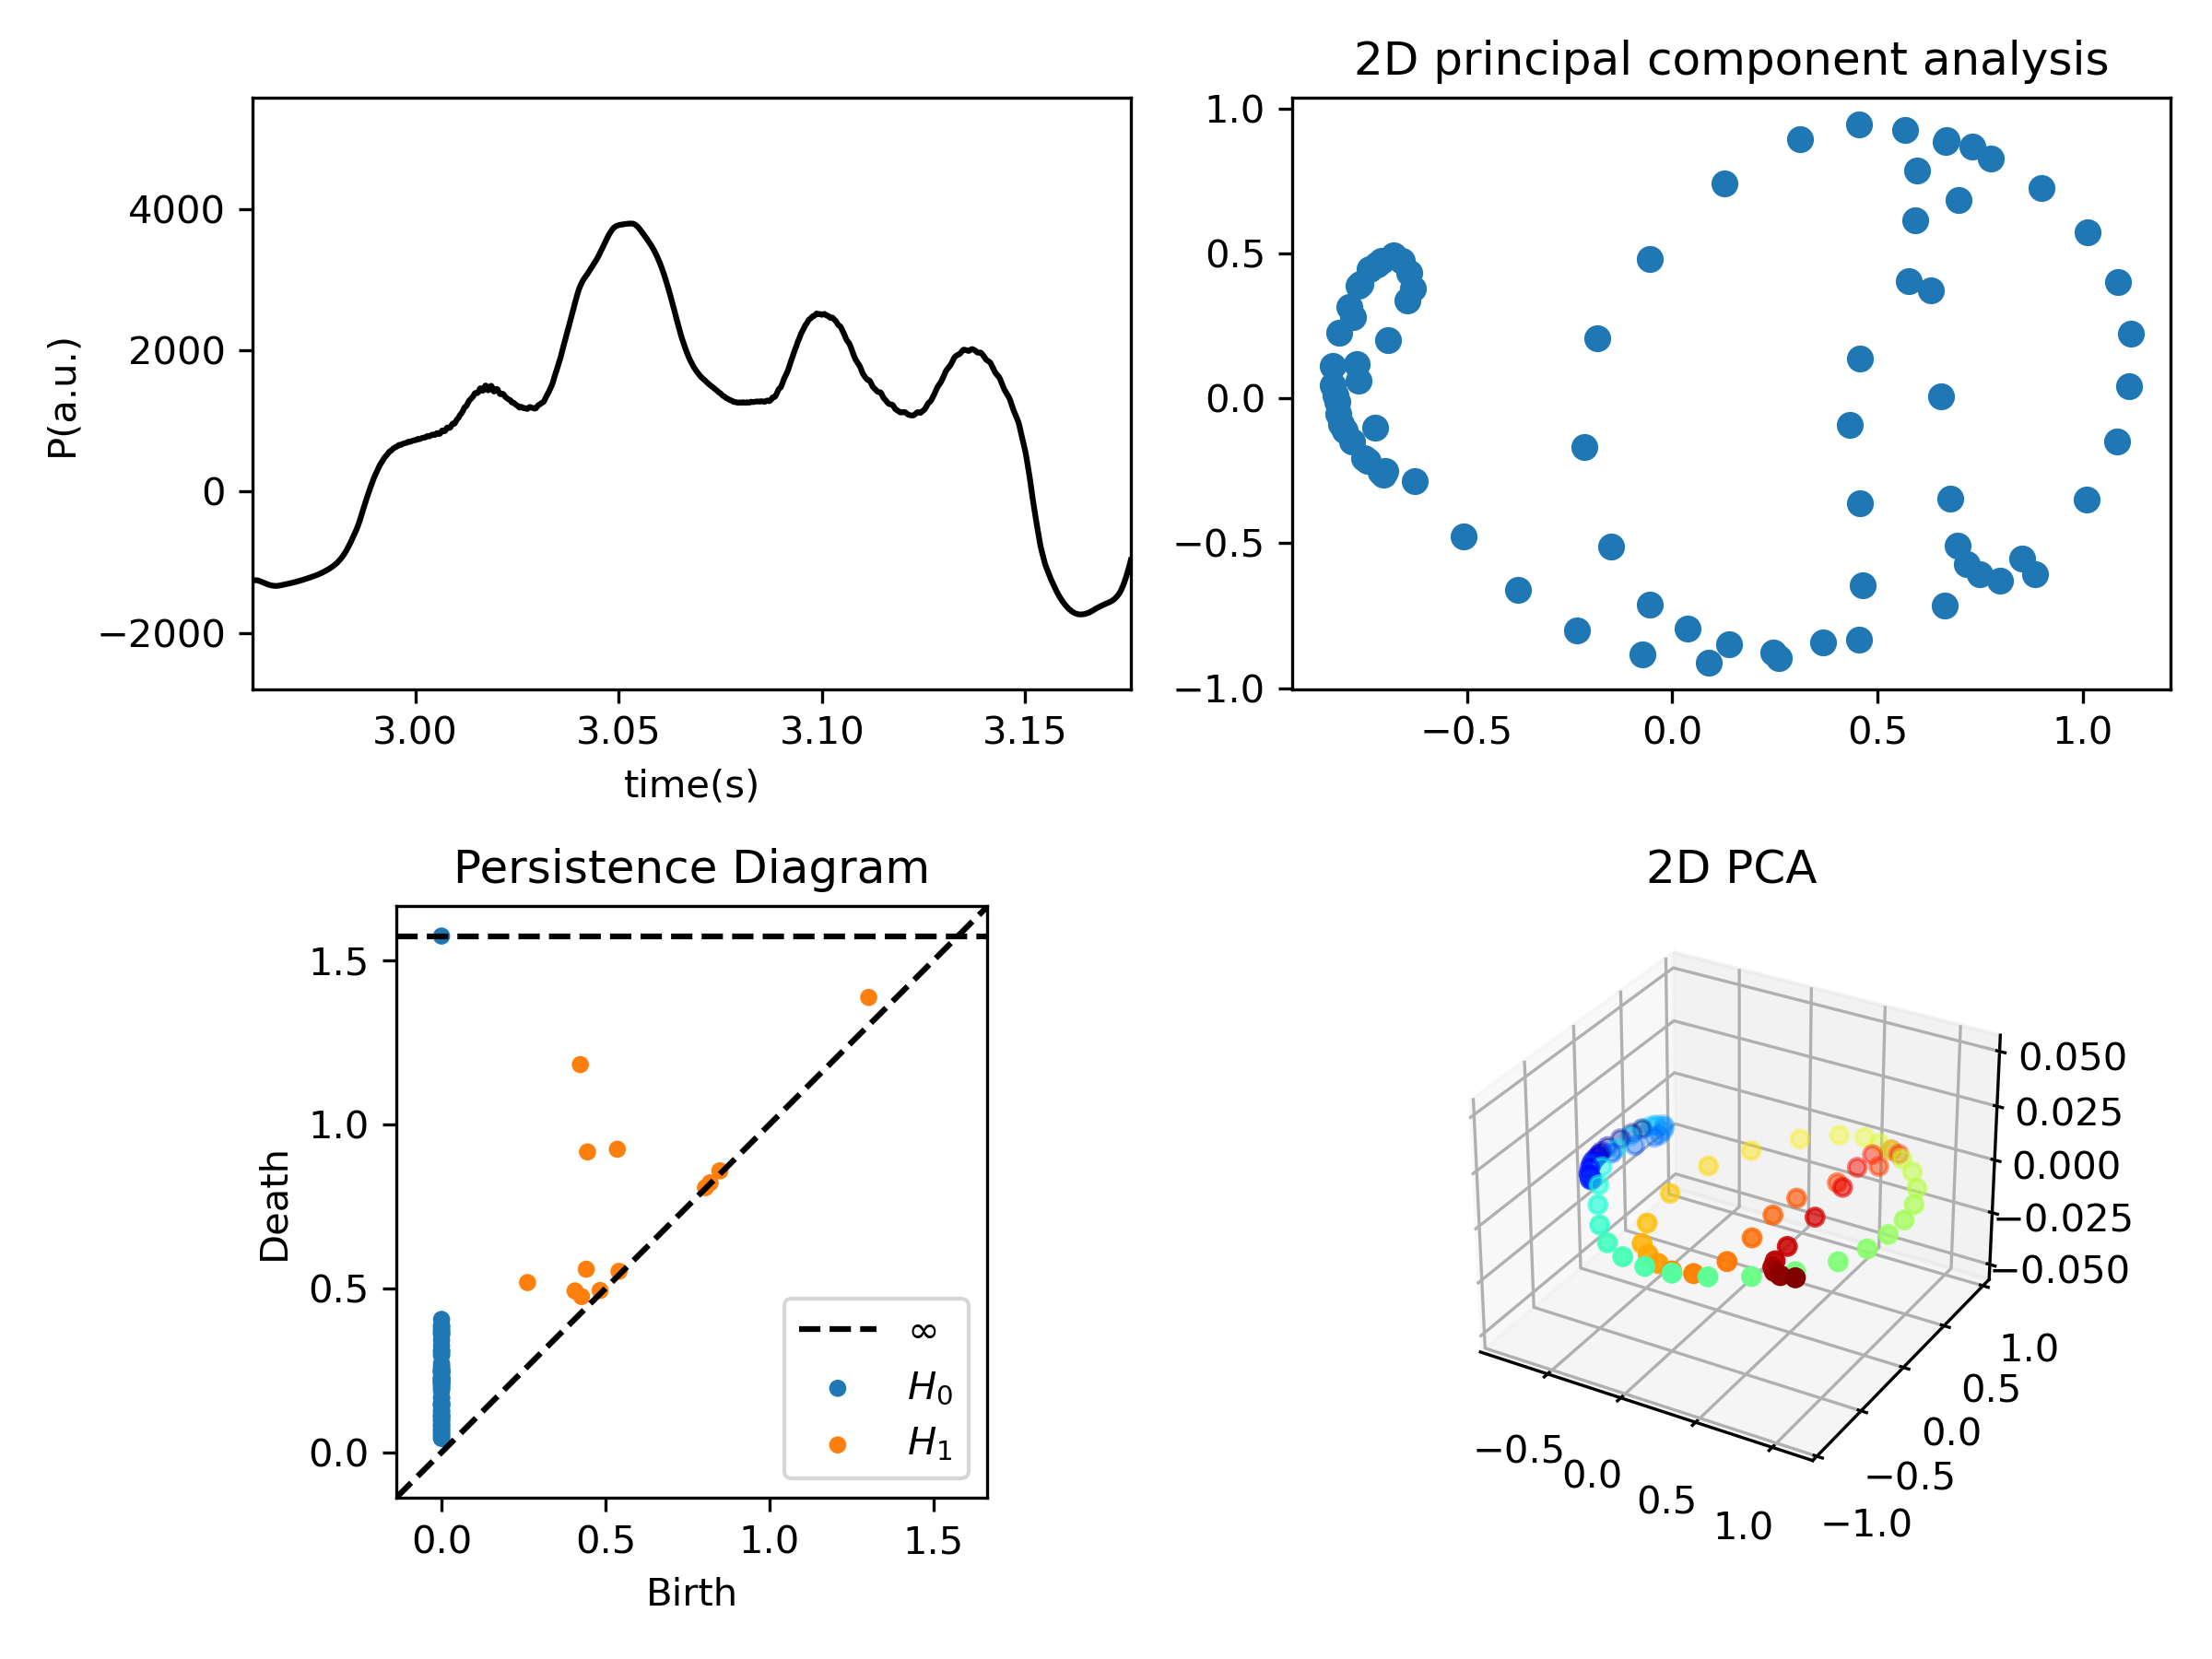

[array([[0.        , 0.04295874],
       [0.        , 0.04310615],
       [0.        , 0.04948945],
       [0.        , 0.05372693],
       [0.        , 0.0562566 ],
       [0.        , 0.06317011],
       [0.        , 0.0665864 ],
       [0.        , 0.0697736 ],
       [0.        , 0.07583211],
       [0.        , 0.08104649],
       [0.        , 0.08346795],
       [0.        , 0.08399319],
       [0.        , 0.09316263],
       [0.        , 0.09775804],
       [0.        , 0.09798471],
       [0.        , 0.10682629],
       [0.        , 0.10755559],
       [0.        , 0.11052722],
       [0.        , 0.11115173],
       [0.        , 0.11271827],
       [0.        , 0.11975579],
       [0.        , 0.12610032],
       [0.        , 0.12741832],
       [0.        , 0.14092258],
       [0.        , 0.14308351],
       [0.        , 0.1437999 ],
       [0.        , 0.14689825],
       [0.        , 0.15089144],
       [0.        , 0.1515076 ],
       [0.        , 0.16479808],
       [0

In [21]:
#Note that dim*Tau here spans a half a second of audio, 
#since Fs is the sample rate

pc = pressure_fil[int(rate*2.96):int(rate*3.176)]

sr=fs
dim = 5
Tau = 350
dT = fs/500

#Get the sliding window embedding
Y = getSlidingWindowInteger(pc[0:fs*3], dim, Tau, dT)
#print("Y.shape = ", Y.shape)

#Mean-center and normalize
Y = Y - np.mean(Y, 1)[:, None]
Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]


#Do Rips Filtration
PDs = ripser(Y, maxdim=1)['dgms']
pca = PCA()
Z = pca.fit_transform(Y)


#Plot original signal, 2-D projection, and the persistence diagram
fig = plt.figure(figsize=(8, 6))

ax1=plt.subplot(221)
#ax1 = plt.subplot(gs[0,0])
ax1.set_ylabel('P(a.u.)')
ax1.set_xlabel('time(s)')
ax1.plot(t, pressure_fil, c='k')
ax1.set_xlim(2.96, 3.176)
    
ax=plt.subplot(222)
ax.set_title("2D principal component analysis")
ax.scatter(Z[:, 0], Z[:, 1])


plt.subplot(223)
plot_diagrams(PDs)
plt.title("Persistence Diagram")

ax=plt.subplot(224,projection = '3d')
c = plt.get_cmap('jet')
C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
C = C[:, 0:3]
ax.set_title("2D PCA")
ax.scatter(Z[:, 0], Z[:, 1],c=C)


print(PDs)
plt.tight_layout()
plt.show()



In [16]:
def lower_star_filtration(x):
    N = len(x)
    # Add edges between adjacent points in the time series, with the "distance" 
    # along the edge equal to the max value of the points it connects
    I = np.arange(N-1)
    J = np.arange(1, N)
    V = np.maximum(x[0:-1], x[1::])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    return ripser(D, maxdim=0, distance_matrix=True)['dgms'][0]

FloatSlider(value=-1739.0611796131357, continuous_update=False, description='\\(\\tau :\\)', max=3793.55468818…

<IPython.core.display.Javascript object>


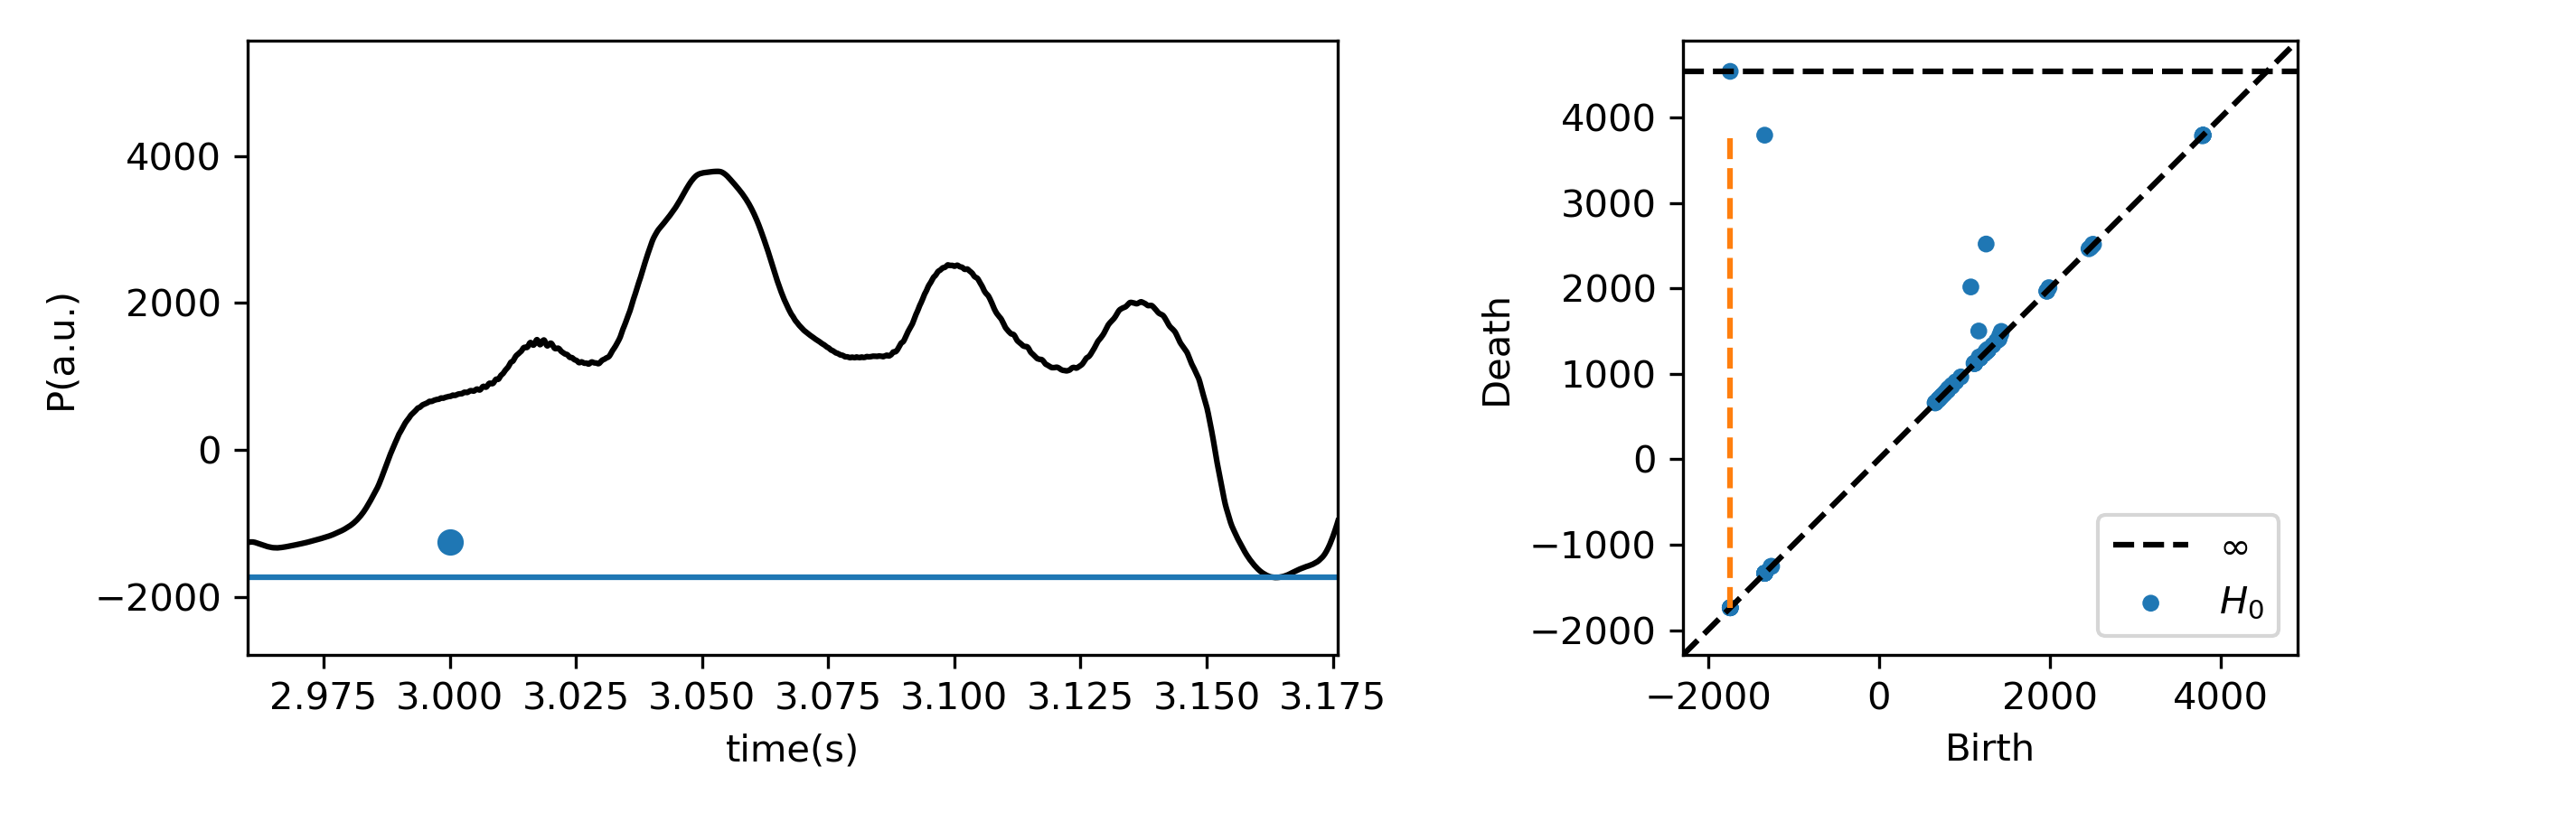

In [17]:

#x=pressure_fil
x=pressure_fil[int(rate*2.96):int(rate*3.176)]

H0 = lower_star_filtration(x)

def on_value_change(change):
    execute_computation1()
Tauslider = widgets.FloatSlider(min=np.min(x)-0.1, max = np.max(x)+0.1, x=5,step=0.05,value=np.min(x)-0.1,description=r'\(\tau :\)' ,continuous_update=False)
Tauslider.observe(on_value_change, names='value')
display(Tauslider)

fig = plt.figure(figsize=(9.5, 3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


def execute_computation1():    
    ax1.clear()
    ax2.clear()
    
    # Get slider values
    cutoff = Tauslider.value
    
    #ax1.plot(x)
    ax1.set_ylabel('P(a.u.)')
    ax1.set_xlabel('time(s)')
    ax1.plot(t, pressure_fil, c='k')
    #ax1.plot(t, pc, c='k')

    ax1.set_xlim(2.96, 3.176)
    
    
    ax1.plot([0, len(x)], [cutoff, cutoff])
    ax1.scatter(np.arange(len(x)), x)
    for i in range(len(x)):
        if x[i] <= cutoff:
            ax1.scatter([i]*2, [x[i]]*2, c='C1')
        if i < len(x)-1:
            if x[i] <= cutoff and x[i+1] <= cutoff:
                ax1.plot([i, i+1], x[i:i+2], c='C1')
    plt.sca(ax2)
    plot_dgms(H0)
    ax2.plot([np.min(x)-0.1, cutoff], [cutoff, cutoff], linestyle='--', c='C1')
    ax2.plot([cutoff, cutoff], [cutoff, np.max(x)+0.6], linestyle='--', c='C1')
    
    plt.tight_layout()

    
execute_computation1()

## Vamos a analizar cual seria la dimension optima de fijacion (embedding). Para esto usaremos una funcion de giotto-tda


In [18]:
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence



max_time_delay = 10
max_embedding_dimension = 2
stride = 5


def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )

    return y_embedded

In [19]:
#Now for the non-periodic case we have:

y_nonperiodic=pressure_fil[int(rate*2.96):int(rate*3.176)]

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="search",
    n_jobs=2,
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

y_nonperiodic_embedded = fit_embedder(embedder_nonperiodic, y_nonperiodic)

Shape of embedded time series: (1381, 2)
Optimal embedding dimension is 2 and time delay is 10


In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
y_nonperiodic_embedded_pca = pca.fit_transform(y_nonperiodic_embedded)
plot_point_cloud(y_nonperiodic_embedded_pca)

In [ ]:
"""y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]
#y_nonperiodic_embedded = y_nonperiodic_embedded_pca[None, :, :]

homology_dimensions = [0, 1, 2]
nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for nonperiodic signal")
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded)"""